In [3]:
import torch
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
from tinyai.imports import *
from torcheval.metrics import *

In [4]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(42)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 100

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

# Load the FashionMNIST dataset from Hugging Face
dataset = load_dataset('mnist')
bs=512*4
epochs = 10
lr = 5e-2
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [5]:
xmean,xstd = -0.3707,0.3088
@inplace
def transformi(b): b['image'] = [(TF.to_tensor(o)-xmean)/xstd for o in b['image']]

In [6]:
dataset = dataset.with_transform(transformi)
dls = DataLoaders.from_dd(dataset,batch_size=bs)

In [7]:
next(iter(dls.train))[0].shape

torch.Size([2048, 1, 28, 28])

In [8]:
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.kaiming_normal_(m.weight, a=leaky)


cbs = [DeviceCB(), ProgressCB(plot=True),MetricsCB(accuracy=MulticlassAccuracy(),precision=MulticlassPrecision(),recall=MulticlassRecall())]
iw = partial(init_weights)
model = get_model(norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls,F.cross_entropy,opt_func=torch.optim.SGD, lr=lr, cbs=cbs)

accuracy,precision,recall,loss,epoch,train
0.488,0.488,0.488,1.700,0,train
0.729,0.729,0.729,1.070,0,eval


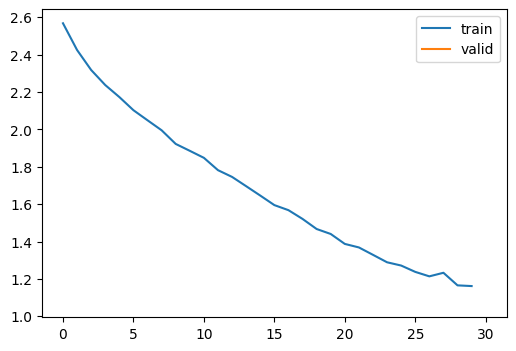

In [9]:
learn.fit(1)

In [67]:
## update the tinyai
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs * 2, **kwargs))

def test_dls(train_ds,test_ds,bs, **kwargs):
    
    test_dl = DataLoader(test_ds, batch_size=bs * 2, **kwargs)
    train_dl,valid_dl = get_dls(train_ds,train_ds,bs)
    return train_dl,valid_dl,test_dl

class DataLoaders:
    def __init__(self, *dls):
        self.train, self.valid = dls[:2]
        self.test = dls[2] if len(dls) > 2 else None

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        if 'test' in dd:
            return cls(*test_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))
        else:
            return cls(*get_dls(dd['train'], dd['valid'], bs=batch_size, collate_fn=f, **kwargs))
        

dls_v2 = DataLoaders.from_dd(dataset,batch_size=bs)

In [68]:
accuracy_metric = MulticlassAccuracy(num_classes=10)
precision_metric = MulticlassPrecision(num_classes=10, average='macro')
recall_metric = MulticlassRecall(num_classes=10, average='macro')

# Prepare for confusion matrix
all_preds = []
all_targets = []
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for data, target in dls_v2.test:
        outputs = model(data)
        preds = torch.argmax(outputs, dim=1)
        
        # Update torcheval metrics
        accuracy_metric.update(preds, target)
        precision_metric.update(preds, target)
        recall_metric.update(preds, target)

        # Store predictions and targets for confusion matrix
        all_preds.append(preds)
        all_targets.append(target)

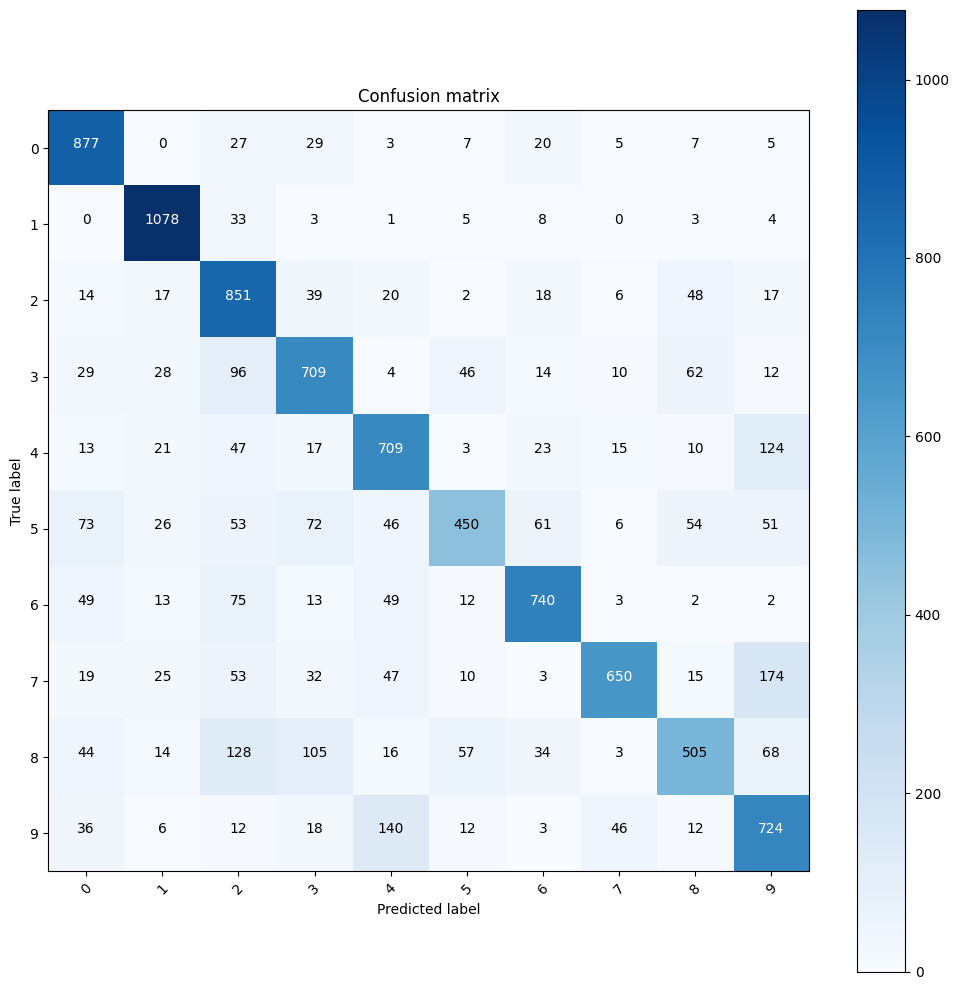

In [69]:
import itertools
from sklearn.metrics import confusion_matrix
all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)
conf_matrix = confusion_matrix(all_targets.cpu(), all_preds.cpu())

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plotting confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(conf_matrix, classes=[str(i) for i in range(10)])  # Assuming class labels are 0-9
plt.show()